In [15]:
# Importando o framework para predição das imagens
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [16]:
# Importando bibliotecas para analises de imagens
import cv2
import imgaug as im
from PIL import Image

# Importando bibliotecas do sistema
import os
import base64

# Importa biblioteca para rede neural
import keras
import segmentation_models as sm
from sklearn import metrics

# Importa bibliotecas para analise de dados
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

# Importa bibliotecas para visualização de dataframes com imagens
import pdfkit as pdf
from io import BytesIO
from IPython.display import HTML


In [17]:
path_name_image = 'D:/Sensix/Python/img_generated/img_original/sugarcane/rgb/'
path_name_image_md = 'D:/Sensix/Python/img_generated/img_original/sugarcane/ground-truth/'

model = sm.Linknet('vgg16', encoder_weights='imagenet')
model_2 = sm.Linknet('vgg16', encoder_weights='imagenet')
model_3 = sm.Linknet('vgg16', encoder_weights='imagenet')

model.load_weights('D:/Sensix/Python/Redes Neurais/diverses_backbones/segment_weed_2.h5')
model_2.load_weights('D:/Sensix/Python/Redes Neurais/marcacoes_externas/vgg16_Linknet_2.hdf5')
model_3.load_weights('D:/Sensix/Python/Redes Neurais/marcacoes_filtro_verde/vgg16_Linknet_Test13.hdf5')

In [18]:
original_img = []

binary_marked = []
binary_model_0 = []
binary_model_1 = []
binary_model_2 = []

real = []
real_marked = []
real_model_0 = []
real_model_1 = []
real_model_2 = []

name_model = ['model','model_2', 'model_3']


In [5]:

for name_image, j in zip(os.listdir(path_name_image), range(30)):
    image_rgb = cv2.imread(path_name_image + name_image)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB) / 255
    original_img.append(image_rgb)

    img = np.array(image_rgb)
    img = img * 255
    img = img.astype(np.uint8)
    real.append(img)
        
    for i in range(3): 
        image = image_rgb.copy()
        pred = eval(str(name_model[i]) + '.predict(np.array([image]))[0]')
        pred = np.array(pred)
        pred = pred[:,:,0]

    pred[pred > 0.1] = 1
    pred[pred < 0.1] = 0
        
        eval('binary_model_' + str(i) + '.append(pred)')

        image = image * 255
        image[pred == 1] = [255,0,0]
        image = image.astype(np.uint8)

        eval('real_model_' + str(i) + '.append(image)')
        
        del pred, image
        

In [6]:
for name_image_md, i in zip(os.listdir(path_name_image_md), range(len(original_img))):
    image_rgb = cv2.imread(path_name_image_md + name_image_md)
    
    image = image_rgb.copy()
    image = np.array(image)
    image = image[:,:,0]

    image[image < 1 ] = 0
    image[image >= 1] = 1
    real_img = original_img[i]

    binary_marked.append(image)

    real_img = real_img * 255   
    real_img[image == 1] = [255,0,0]
    real_img = real_img.astype(np.uint8)
    
    real_marked.append(real_img)

In [7]:
def get_thumbnail(path):
    i = Image.fromarray(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [8]:
dict_predict_images = {'path_imgs': real, 'path_marked': real_marked, 'path_model_0': real_model_0, 'path_model_1': real_model_1, 'path_model_2': real_model_2}

In [9]:
df = pd.DataFrame(dict_predict_images)

In [10]:
df['imgs'] = df.path_imgs.map(lambda f: get_thumbnail(f))
df['imgs_marked'] = df.path_marked.map(lambda f: get_thumbnail(f))
df['model_0'] = df.path_model_0.map(lambda f: get_thumbnail(f))
df['model_1'] = df.path_model_1.map(lambda f: get_thumbnail(f))
df['model_2'] = df.path_model_2.map(lambda f: get_thumbnail(f))

In [11]:
table = HTML(df[['imgs', 'imgs_marked',
                 'model_0', 
                 'model_1', 
                 'model_2']].to_html(#'table.html', 
                                         formatters={'imgs': image_formatter,
                                         'imgs_marked': image_formatter,
                                         'model_0': image_formatter,
                                         'model_1': image_formatter,
                                         'model_2': image_formatter},
                                         escape=False))

#pdf.from_file('table.html', 'table.pdf')

In [12]:
dict_metrics = {'metrics_model_0': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []},
                'metrics_model_1': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []},
                'metrics_model_2': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []}}

for i in range(3):
    for j in range(len(binary_marked)):
        vl_jac = round(metrics.jaccard_score(eval('binary_model_' + str(i) + '[j]'), binary_marked[j], average='micro'), 2)
        vl_dic = round(metrics.f1_score(binary_marked[j], eval('binary_model_' + str(i) + '[j]'), average='micro'), 2)
        vl_pre = round(metrics.precision_score(binary_marked[j], eval('binary_model_' + str(i) + '[j]'), average='micro'), 2)
        vl_acc = round(metrics.accuracy_score(binary_marked[j], eval('binary_model_' + str(i) + '[j]')), 2)
        
        x = str(('metrics_model_' + str(i)))

        dict_metrics[x]['vl_jac'].append(vl_jac)
        dict_metrics[x]['vl_dic'].append(vl_dic)
        dict_metrics[x]['vl_pre'].append(vl_pre)
        dict_metrics[x]['vl_acc'].append(vl_acc)

        del vl_jac, vl_dic, vl_pre, vl_acc

C:\Users\flavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
dict_of_df = {k: pd.DataFrame(v) for k,v in dict_metrics.items()}
df_metrics = pd.concat(dict_of_df, axis=1)

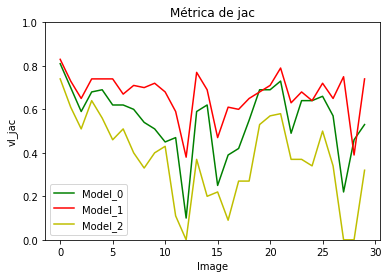

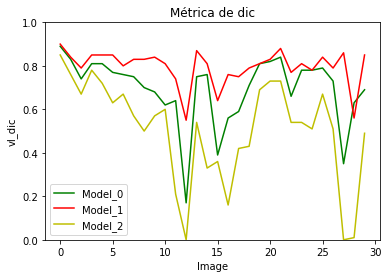

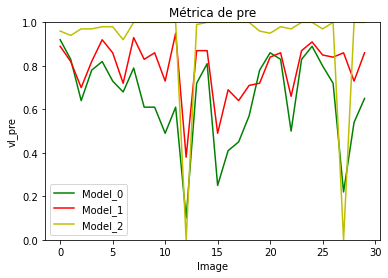

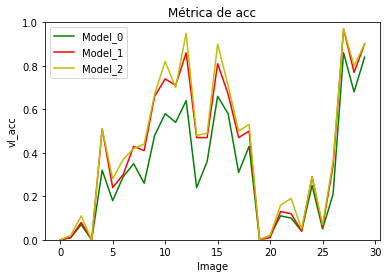

In [14]:
name_metrics = ['vl_jac', 'vl_dic', 'vl_pre', 'vl_acc']


for name in name_metrics:
    mm_0 = df_metrics['metrics_model_0'][str(name)]
    mm_1 = df_metrics['metrics_model_1'][str(name)]
    mm_2 = df_metrics['metrics_model_2'][str(name)]

    indx = df_metrics.index

    fig, ax = plt.subplots()
    ax.set_ylim(0, 1)
    plt.plot(indx, mm_0, 'g', label = 'Model_0')
    plt.plot(indx, mm_1, 'r', label = 'Model_1')
    plt.plot(indx, mm_2, 'y', label = 'Model_2')
    plt.ylabel(str(name))
    plt.xlabel('Image')
    r = re.sub("vl_","", str(name))
    plt.title('Métrica de ' + str(r))
    plt.legend(loc='best')
    plt.show()

    del mm_0, mm_1, mm_2


In [15]:
df_metrics

metrics_model_0                      metrics_model_1                       \
            vl_jac vl_dic vl_pre vl_acc          vl_jac vl_dic vl_pre vl_acc   
0             0.81   0.89   0.92   0.00            0.83   0.90   0.89   0.00   
1             0.70   0.83   0.83   0.01            0.73   0.84   0.82   0.01   
2             0.59   0.74   0.64   0.07            0.65   0.79   0.70   0.08   
3             0.68   0.81   0.78   0.00            0.74   0.85   0.82   0.00   
4             0.69   0.81   0.82   0.32            0.74   0.85   0.92   0.51   
5             0.62   0.77   0.73   0.18            0.74   0.85   0.86   0.24   
6             0.62   0.76   0.68   0.29            0.67   0.80   0.72   0.30   
7             0.60   0.75   0.79   0.35            0.71   0.83   0.93   0.43   
8             0.54   0.70   0.61   0.26            0.70   0.83   0.83   0.41   
9             0.51   0.68   0.61   0.48            0.72   0.84   0.86   0.66   
10            0.45   0.62   0.49   0.58            0.68   0.81   0.73   0.74   
11            0.47   0.64   0.61   0.54            0.59   0.74   0.95   0.71   
12            0.10   0.17   0.10   0.64            0.38   0.55   0.38   0.86   
13            0.59   0.75   0.72   0.24            0.77   0.87   0.87   0.47   
14            0.62   0.76   0.81   0.36            0.69   0.81   0.87   0.47   
15            0.25   0.39   0.25   0.66            0.47   0.64   0.49   0.81   
16            0.39   0.56   0.41   0.58            0.61   0.76   0.69   0.67   
17            0.42   0.59   0.45   0.31            0.60   0.75   0.64   0.47   
18            0.55   0.71   0.57   0.43            0.65   0.79   0.71   0.50   
19            0.69   0.81   0.78   0.00            0.68   0.81   0.72   0.00   
20            0.69   0.82   0.86   0.02            0.71   0.83   0.84   0.01   
21            0.73   0.84   0.83   0.11            0.79   0.88   0.86   0.13   
22            0.49   0.66   0.50   0.10            0.63   0.77   0.66   0.12   
23            0.64   0.78   0.83   0.04            0.68   0.81   0.87   0.04   
24            0.64   0.78   0.89   0.25            0.64   0.78   0.91   0.29   
25            0.66   0.79   0.80   0.05            0.72   0.84   0.85   0.06   
26            0.57   0.73   0.72   0.21            0.65   0.79   0.84   0.34   
27            0.22   0.35   0.22   0.86            0.75   0.86   0.86   0.97   
28            0.46   0.63   0.54   0.68            0.39   0.56   0.73   0.77   
29            0.53   0.69   0.65   0.84            0.74   0.85   0.86   0.90   

   metrics_model_2                       
            vl_jac vl_dic vl_pre vl_acc  
0             0.74   0.85   0.96   0.00  
1             0.61   0.76   0.94   0.02  
2             0.51   0.67   0.97   0.11  
3             0.64   0.78   0.97   0.00  
4             0.56   0.72   0.98   0.51  
5             0.46   0.63   0.98   0.28  
6             0.51   0.67   0.92   0.37  
7             0.40   0.57   1.00   0.42  
8             0.33   0.50   1.00   0.44  
9             0.40   0.57   1.00   0.67  
10            0.43   0.60   1.00   0.82  
11            0.11   0.21   1.00   0.70  
12            0.00   0.00   0.00   0.95  
13            0.37   0.54   0.99   0.48  
14            0.20   0.33   1.00   0.49  
15            0.22   0.36   1.00   0.90  
16            0.09   0.16   1.00   0.71  
17            0.27   0.42   1.00   0.50  
18            0.27   0.43   1.00   0.53  
19            0.53   0.69   0.96   0.00  
20            0.57   0.73   0.95   0.02  
21            0.58   0.73   0.98   0.16  
22            0.37   0.54   0.97   0.19  
23            0.37   0.54   1.00   0.05  
24            0.34   0.51   1.00   0.29  
25            0.50   0.67   0.97   0.07  
26            0.34   0.51   1.00   0.36  
27            0.00   0.00   0.00   0.97  
28            0.00   0.01   1.00   0.80  
29            0.32   0.49   1.00   0.90

,imgs,imgs_marked,model_0,model_1,model_2
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,
5,,,,,
6,,,,,
7,,,,,
8,,,,,
9,,,,,

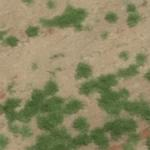
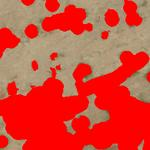
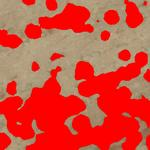
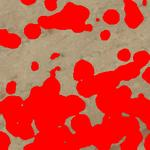
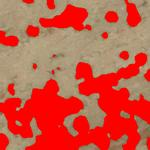
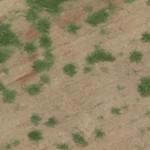
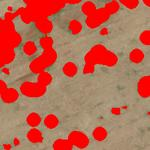
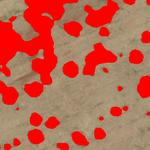
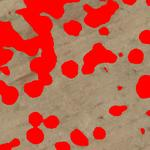
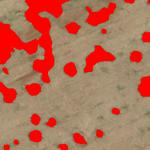
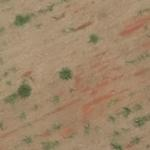
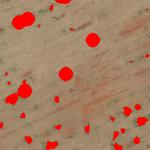
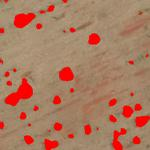
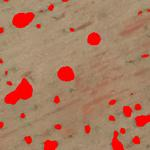
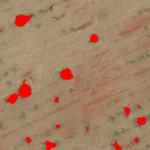
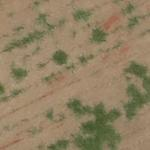
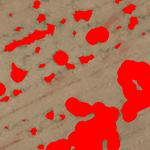
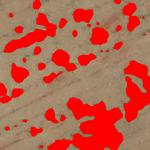
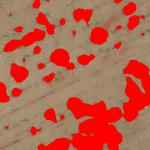
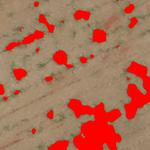
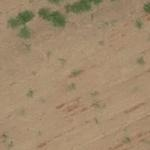
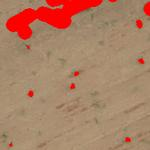
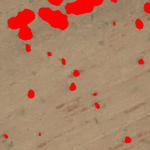
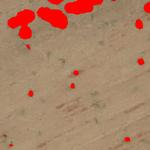
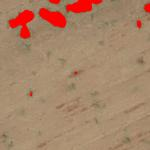
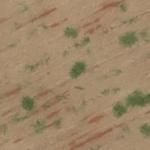
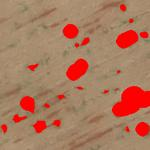
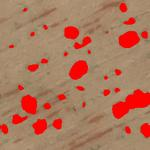
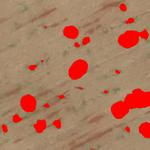
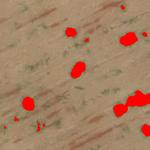
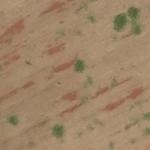
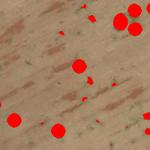
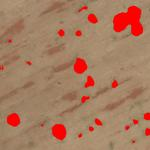
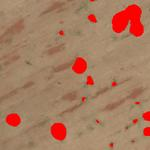
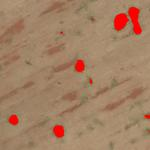
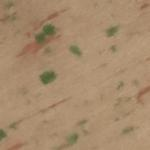
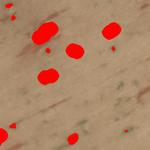
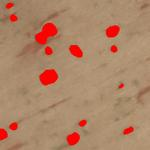
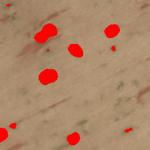
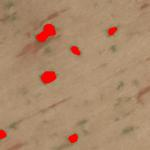
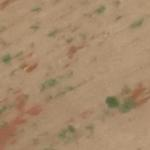
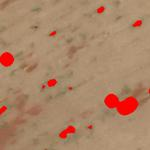
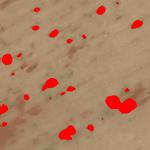
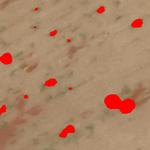
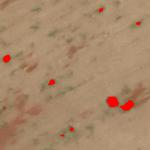
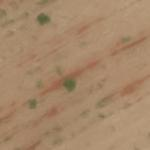
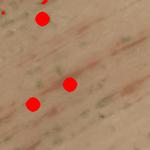
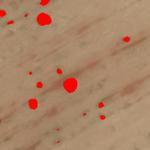
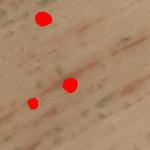
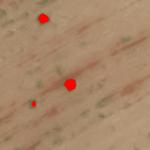
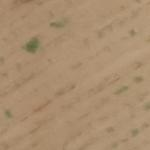
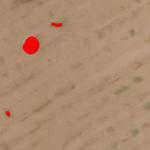
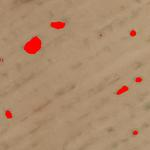
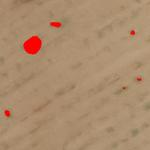
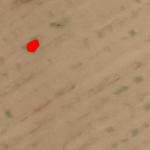
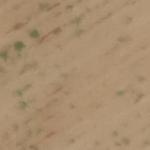
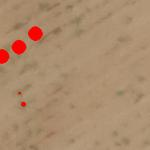
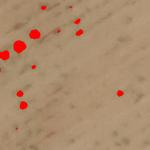
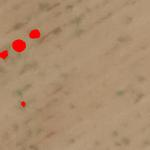
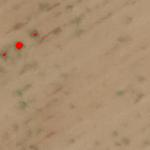
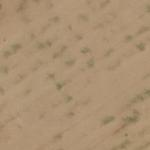
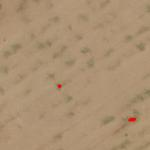
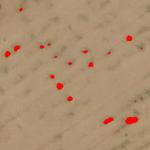
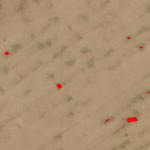
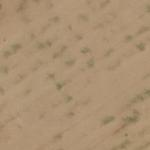
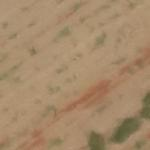
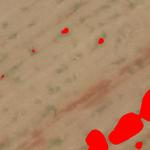
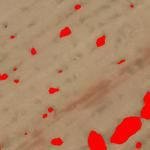
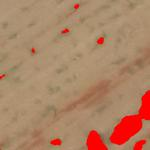
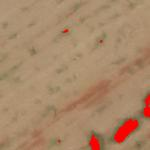
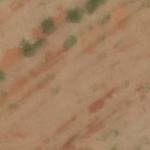
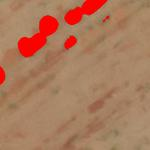
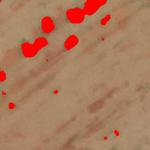
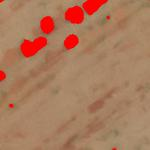
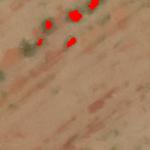
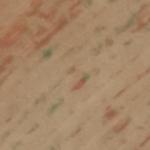
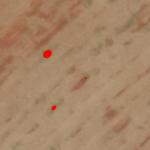
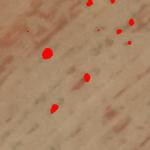
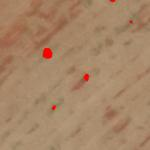
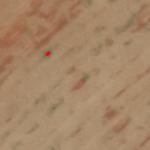
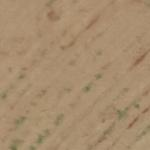
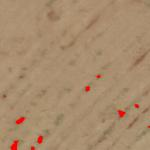
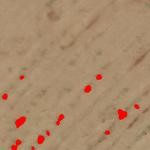
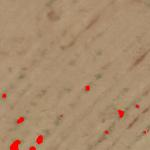
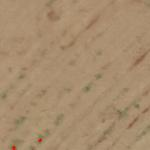
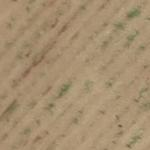
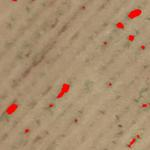
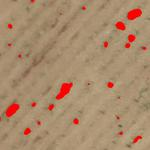
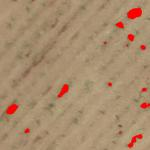
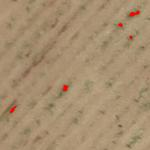
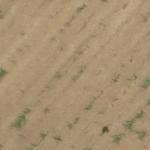
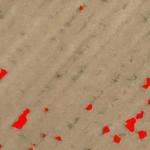
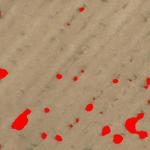
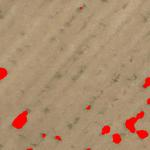
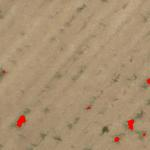
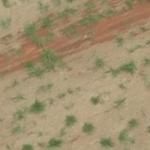
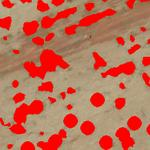
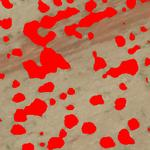
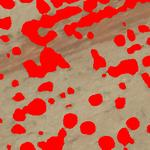
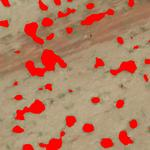
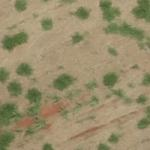
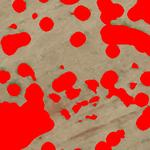
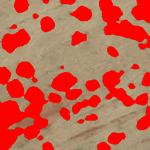
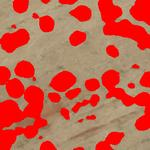
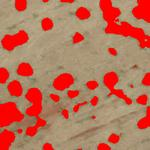
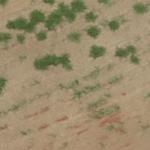
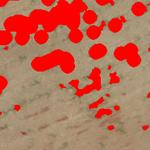
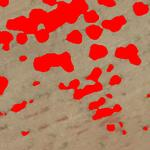
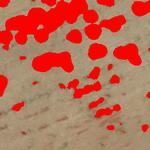
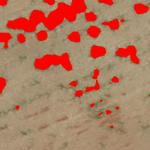
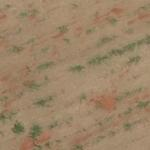
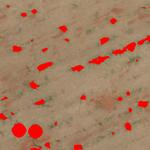
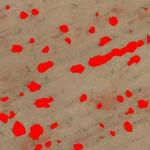
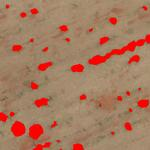
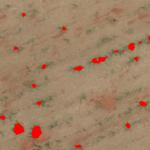
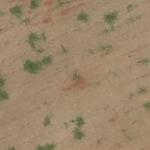
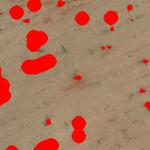
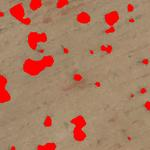
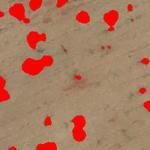
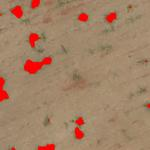
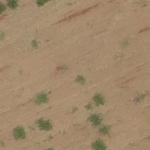
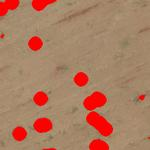
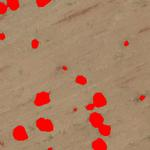
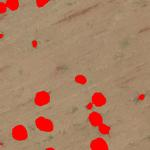
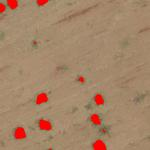
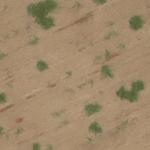
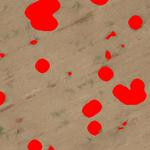
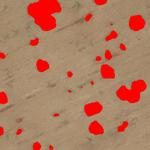
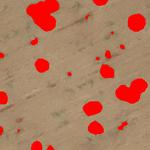
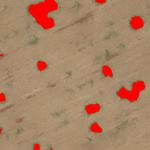
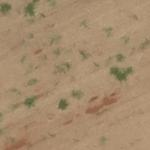
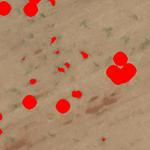
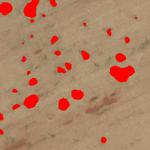
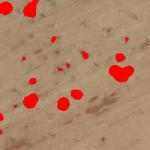
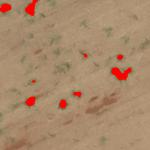
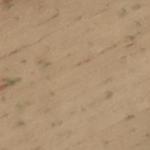
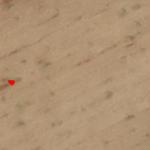
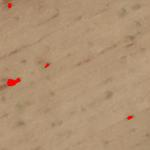
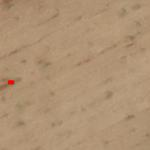
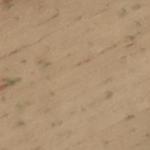
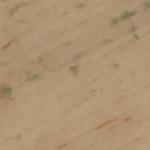
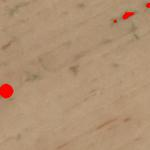
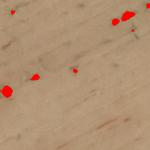
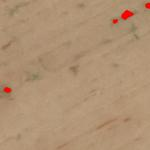
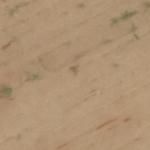
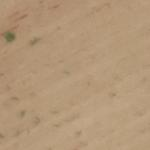
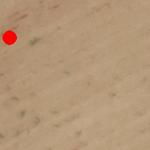
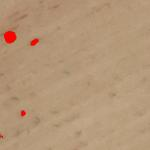
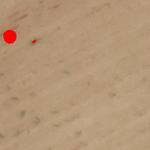
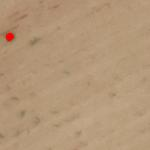

In [16]:
table